# Exploring Ectomycorrhizal Diversity and NEON Data

In [2]:
import pandas as pd
import numpy as np 
import geopandas as gpd 
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 
import os 
import scipy.stats

import warnings
warnings.filterwarnings("ignore")


## Outline
1. Data read in
2. Data management and cleaning, show that you understand how to evaluate the quality of the data before conducting your analysis
    a. Looking for null values
    b. Exploring the range of values included
    c. Looking for outliers
    d. Looking for spatial relationships in the variables (plotting climate across domains, ensuring annual precip/temperature values are shared by samples taken during the same year)
3. Creating diversity indices
    a. Exploring the ideas of evenness and richness (comparing relative abundance to observation counts)
    b. Create diversity indices justified by the exploration
    c. Compare spatial distributions of diversity across domains
4. Relating climate and fungal diversity
    a. Mention papers that you've read about the subject. Explore relationships between soil ph and diversity
    b. Explore the relationship between climate variables and diversity 
    c. ANOVA and Tuskeys HD between climate and diversity
    d. Explore regressions for each domain which fit precipitation/temperature to diversity
5. Visualize
    a. Create a visualization of findings
    b. Clean up visualization in illustrator/photoshop

    Final: 
    1. Data read
    2. EDA - Finding strong correlation between some of the climate variables and looking at significant differences in the distribution of the target (diversity/shannon) across plots and domains (distplots hue=domain/plot)
        a. Justifying the use of Ridge Regression for predicting diversity with the climate variables as input given the colinearity
    3. Quantifying the ridge regression relationship 
    4. Creating a visualization 


## Reading in the Data

In [44]:
#Data lives in "data" directory

#Read in NEON Domain Shapefile
neon_domains_gdf = gpd.read_file("../data/NEONDomains_0/NEON_Domains.shp")

#Read in NEON metadata
metadata = pd.read_csv("../data/NEON_metadata.csv")

#Spatialize NEON metadata
metadata_geom = gpd.GeoSeries.from_xy(metadata['longitude'], metadata['latitude'])
metadata_gdf = gpd.GeoDataFrame(metadata, geometry=metadata_geom) 
metadata['domain'] = gpd.sjoin(metadata_gdf, neon_domains_gdf, how="inner", op="within")['DomainName']

#Create groupings for each site and collection
metadata['site'] = metadata['plotID'].apply(lambda s: s[:4])
metadata['collectDate'] = pd.to_datetime(metadata['collectYear'] * 1000 + metadata['collectDOY'], format="%Y%j")

metadata_columns = metadata.columns

#Read in EcM observations
ecm_observations = pd.read_csv("../data/NEON_species_table.csv")
species_columns = ecm_observations.columns[3:]

## Joining Abundance Observations to Site Data

In [45]:
#Merging Metadata and EcM observations
clim_ecm_abundance = metadata.merge(ecm_observations.drop(columns = ["plotID", "collectYear", "collectDOY"]), how="inner", left_index=True, right_index=True)

# Exploring and Cleaning

### Descriptive Stats
Descriptive stats show that 100 EcM species which were sequenced for were not observed in the DNA pool of the samples. Additionally, Soil pH and soil moisture are not present for every row. 

Infinite values are not being used as no-value fills and outliers may exist within sampling sites, but do not stand out when looking at the entire dataset.

In [46]:
#Generate descriptive statistics for each column
clim_ecm_abundance_desc = clim_ecm_abundance.describe() #Shows some species do not appear in the samples
clim_ecm_abundance_desc 

#Temperature Seasonality is the standard deviation of mean annual temperature * 100
#Precipitation Seasonality is the coefficient of variation of annual precipitation (std/mean)

,longitude,latitude,collectYear,collectDOY,soil_pH,soil_moisture,temp_celsius,precip_mm,temp_seasonality,precip_seasonality,...,Rhizopogon_nitidus,Lactarius_pubescens,Inocybe_apiosmota,Tomentella_pyrolae,Cantharellus_hygrophoroides,Inocybe_fuligineoatra,Russula_pectinata,Russula_pallidospora,Byssocorticium_caeruleum,Sarcodon_leucopus
count,6197.000000,6197.000000,6197.000000,6197.000000,6099.000000,6038.000000,6197.000000,6197.000000,6197.000000,6197.000000,...,6197.0,6197.0,6197.0,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000
mean,-94.523030,38.767554,2016.990802,203.707762,5.270943,0.624494,11.105254,920.601995,82.409577,39.950461,...,0.0,0.0,0.0,0.008391,0.008391,0.008391,0.008391,0.008230,0.008230,0.008230
std,17.851073,8.688026,0.785652,79.617944,1.406769,1.378021,7.224745,449.814514,26.217092,23.176000,...,0.0,0.0,0.0,0.660560,0.296734,0.222798,0.522194,0.312371,0.254266,0.647857
min,-156.648849,17.963818,2014.000000,50.000000,2.000000,0.001000,-12.300000,117.000000,11.498194,7.401515,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-104.746715,33.403989,2016.000000,131.000000,4.190000,0.131000,5.400000,462.000000,71.540000,16.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-90.092743,39.045354,2017.000000,200.000000,5.170000,0.247000,11.634667,874.077320,84.410000,41.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-81.960693,44.041571,2018.000000,283.000000,6.405000,0.459750,16.200000,1300.000000,96.960000,58.210762,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,-66.824633,71.285604,2018.000000,354.000000,9.070000,21.955000,25.919444,2386.882353,145.338461,82.000000,...,0.0,0.0,0.0,52.000000,16.000000,11.000000,39.000000,15.000000,11.000000,51.000000


In [47]:
#No need to drop empty columns, just keep a list of absent species
absent_species = clim_ecm_abundance_desc.columns[clim_ecm_abundance_desc.loc['max'] == 0]

### Exploring Differences at Sites

In [48]:
clim_ecm_abundance.groupby(['site'])['soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm'].agg(['min', 'max', 'mean', 'std', 'var'])

#Does precip_mm change between years
clim_ecm_abundance.groupby(['plotID', 'collectYear'])['precip_mm'].agg(lambda g: max(g) - min(g)).value_counts() #Shows that at each plot, the precipitation_mm which I thought was an annual total doesn't change year to year.

0.0    1006
Name: precip_mm, dtype: int64

In [49]:
#By PlotID look at fungal diversity ranges
clim_ecm_abundance.groupby('plotID').agg(
    delta = ('fungal_diversity', lambda g: max(g) - min(g)),
    std = ('fungal_diversity', np.std),
    var = ('fungal_diversity', np.var)
    ).sort_values('std', ascending=False).head() #Shows high variance in fungal diversity at some sites and noteworthy conditional variance

,delta,std,var
plotID,,,
WREF_005,39,15.501613,240.30
KONA_003,29,13.939153,194.30
ABBY_070,41,13.137732,172.60
UNDE_013,27,12.093387,146.25
BART_001,43,12.020815,144.50


In [50]:
#Does a site get repeatedly sampled over time?
clim_ecm_abundance.groupby('plotID')['collectDate'].agg(lambda g: len(g.unique()))

plotID
ABBY_001    4
ABBY_002    4
ABBY_003    4
ABBY_004    4
ABBY_006    4
           ..
YELL_016    2
YELL_046    2
YELL_048    2
YELL_051    2
YELL_052    2
Name: collectDate, Length: 474, dtype: int64

In [51]:
#Annual Precip and Temperature values are 1:1 associated with sites, not with collection years.
#Even though plots are sampled over multiple years and over multiple water years, the annual precip and temperature stay the same.
clim_ecm_abundance.groupby('plotID')['precip_mm'].agg(lambda g: len(g.unique()))
clim_ecm_abundance.groupby('plotID')['temp_celsius'].agg(lambda g: len(g.unique()))

plotID
ABBY_001    1.0
ABBY_002    1.0
ABBY_003    1.0
ABBY_004    1.0
ABBY_006    1.0
           ... 
YELL_016    1.0
YELL_046    1.0
YELL_048    1.0
YELL_051    1.0
YELL_052    1.0
Name: temp_celsius, Length: 474, dtype: float64

### Calculating Relative Abundance for each Sample

In [52]:
#Calculate Relative Abundance
clim_ecm_abundance['count_observations'] = clim_ecm_abundance[species_columns].sum(axis=1)

#Assert no zero counts are present
assert not any(clim_ecm_abundance['count_observations'] == 0)

#Calculate relative abundances
clim_ecm_abundance[species_columns] = clim_ecm_abundance[species_columns].div(clim_ecm_abundance['count_observations'], axis=0)

In [53]:
#Climate Variables and Alpha Diversity Index (Shannon Diversity)
clim_sdi = clim_ecm_abundance[metadata_columns]
clim_sdi.loc[:, 'shannon_diversity'] = -(clim_ecm_abundance[species_columns] * np.log(clim_ecm_abundance[species_columns], where=clim_ecm_abundance[species_columns] != 0)).sum(axis=1)

<AxesSubplot:xlabel='fungal_diversity', ylabel='shannon_diversity'>

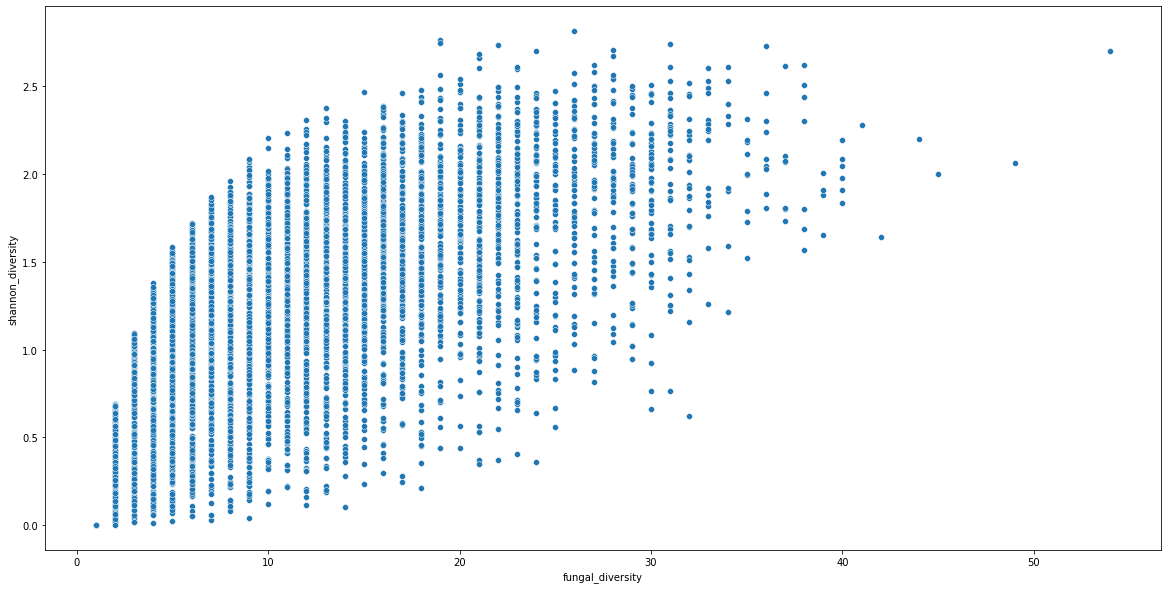

In [54]:
#Compare Shannon Diversity to Fungal Diversity ranking
plt.figure(figsize=(20,10))
sns.scatterplot(data = clim_sdi, x="fungal_diversity", y="shannon_diversity")

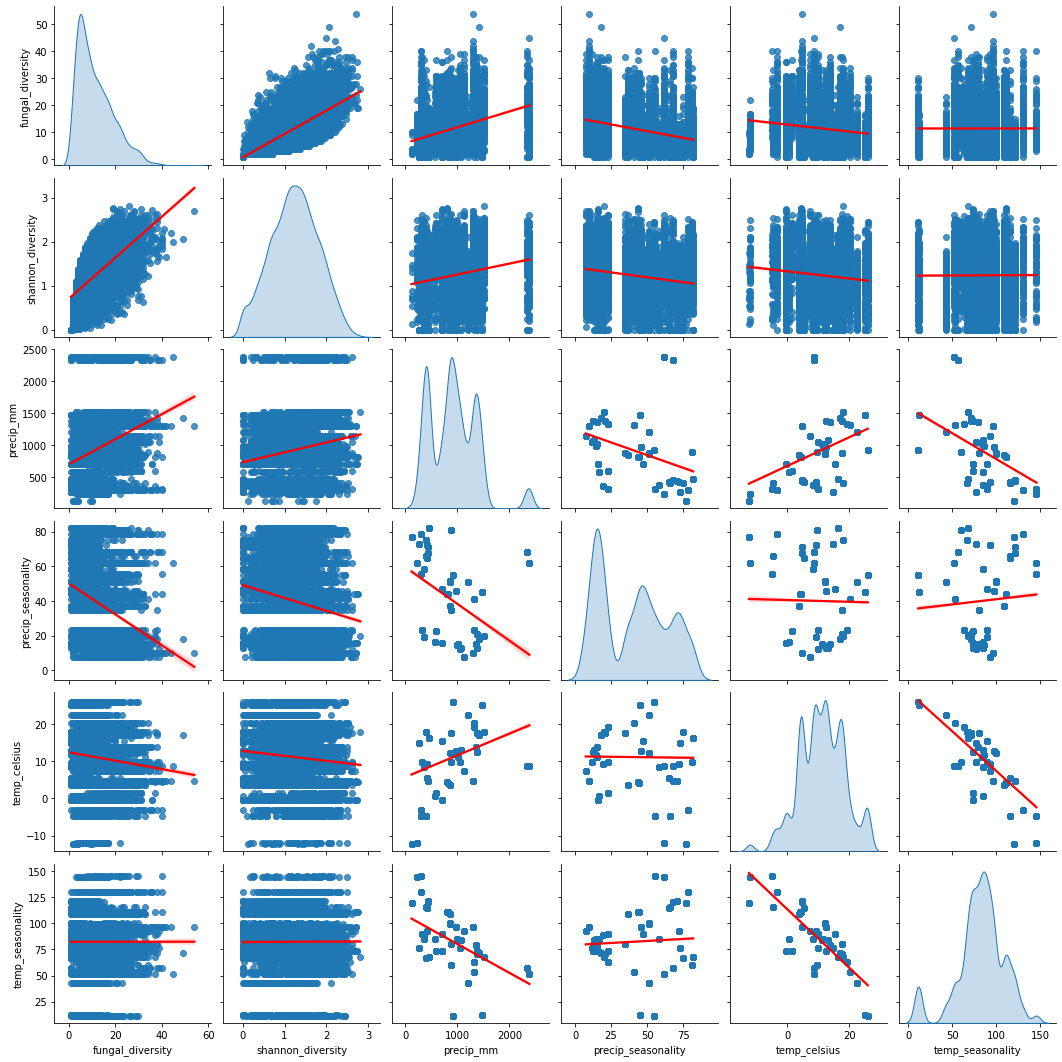

In [55]:
def PlotCorrelationCoefficient(x, y, ax, **kwargs):
    r, p = pearsonr(x, y)
    ax.annotate(f'r = {r.round(2)}')
    
corrplot = sns.pairplot(data=clim_sdi[['fungal_diversity', 'shannon_diversity', 'precip_mm', 'precip_seasonality', 'temp_celsius','temp_seasonality']], kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'red'}})
# corrplot.map_lower(PlotCorrelationCoefficient)
# plt.show()

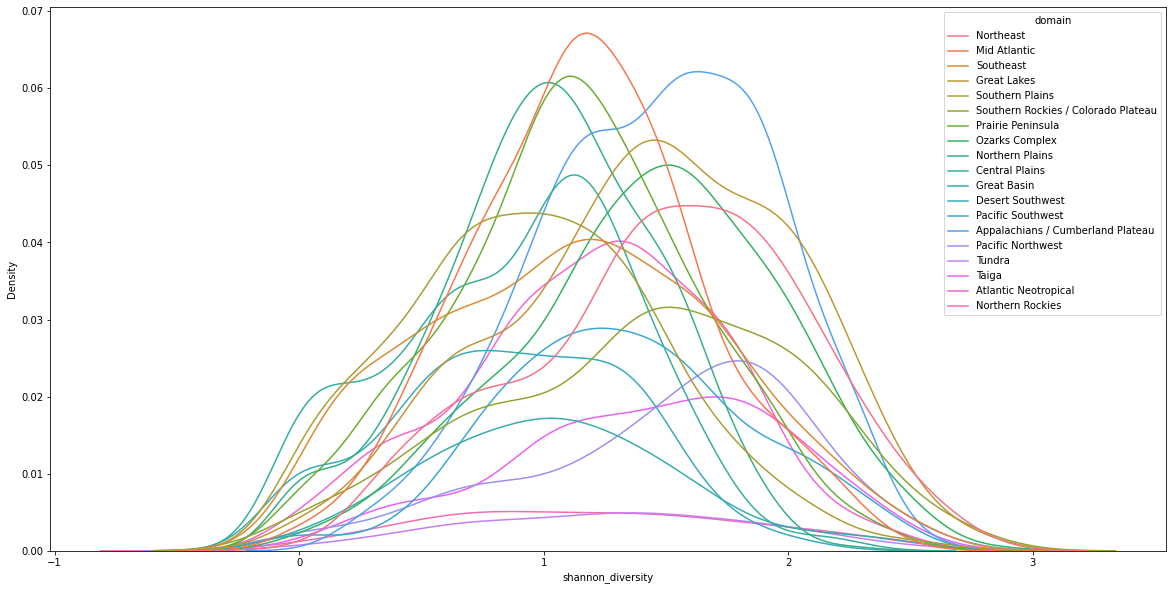

In [15]:
#Compare distributions of shannon diversity between sites
plt.figure(figsize=(20,10))
sns.kdeplot(clim_sdi, x="shannon_diversity", hue="domain");

<AxesSubplot:ylabel='shannon_diversity'>

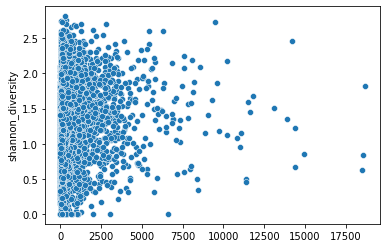

In [16]:
sns.scatterplot(x=clim_sdi['soil_moisture'] * clim_sdi['precip_mm'], y=clim_sdi['shannon_diversity'])

In [17]:
#Calculate bins for temp seasonality, temp celsius, precip mm, and precip_seasonality


<AxesSubplot:>

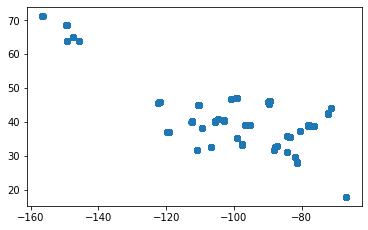

In [18]:
metadata_gdf.plot()

In [19]:
# clim_sdi['plot_group'] = clim_sdi['plotID'].apply(lambda s: s[:4])
# clim_sdi['collectDate'] = pd.to_datetime(clim_sdi['collectYear']*1000 + clim_sdi['collectDOY'], format="%Y%j")

F_onewayResult(statistic=52.10508159274605, pvalue=4.761448531001311e-174)

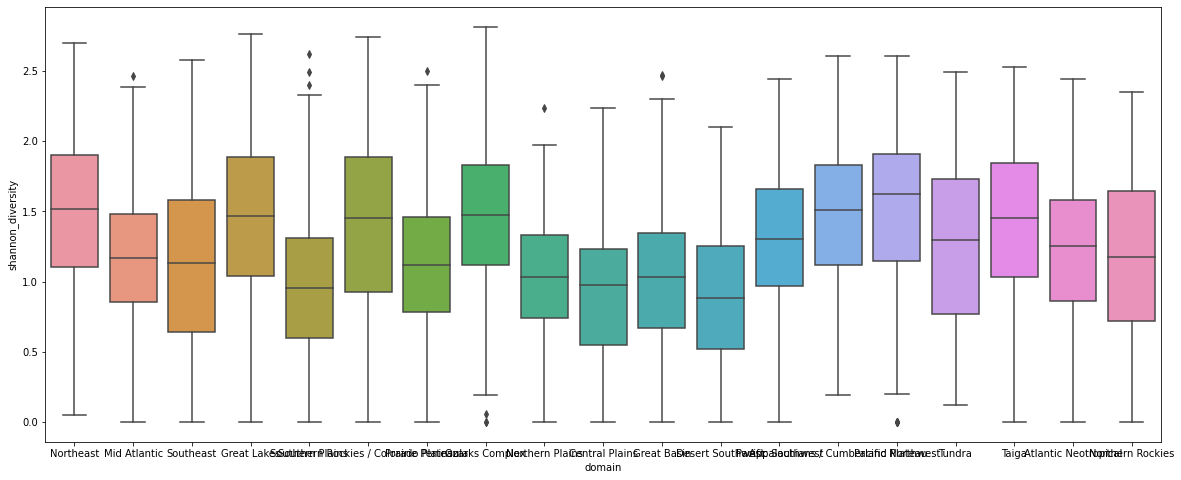

In [20]:
#Understanding differences in shannon diversity across domains and plots
plt.figure(figsize=(20,8))
sns.boxplot(data = clim_sdi, x="domain", y='shannon_diversity')

clim_sdi_by_domain = clim_sdi.groupby("domain")

# domain_to_clim_sdi = {}
domain_to_clim_sdi = [domain_data['shannon_diversity'].values for domain, domain_data in clim_sdi_by_domain]
    # domain_to_clim_sdi[domain] = domain_data['shannon_diversity'].values

scipy.stats.f_oneway(*domain_to_clim_sdi) #Obvious but good to check



In [21]:
soil_moisture_sdi = clim_sdi[['soil_moisture', 'shannon_diversity']].dropna()
scipy.stats.pearsonr(soil_moisture_sdi['soil_moisture'], soil_moisture_sdi['shannon_diversity'])

(0.07935858475778924, 6.616844850082454e-10)

In [ ]:
domain_facet = sns.FacetGrid(clim_sdi, col="domain", col_wrap=4)
domain_facet.map_dataframe(sns.boxplot, x="soil_pH", y="shannon_diversity", hue="soil_pH")  

In [ ]:
ph_sdi = clim_sdi[['soil_pH', 'shannon_diversity']].dropna()
scipy.stats.pearsonr(ph_sdi['soil_pH'], ph_sdi['shannon_diversity'])

(-0.24709155845395414, 1.621811371232406e-85)

# Lets work with just soil ph, and precipitation

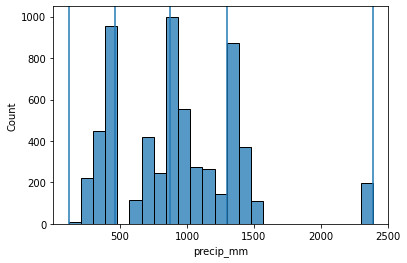

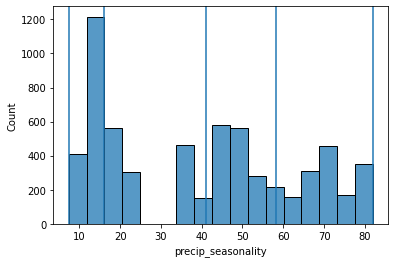

In [126]:
#Bin precipitation
precip_mm_binned, precip_mm_bins = pd.qcut(clim_sdi['precip_mm'], 4, retbins=True)
precip_seasonality_binned, precip_seasonality_bins = pd.qcut(clim_sdi['precip_seasonality'], 4, retbins=True)

fig, ax = plt.subplots()

sns.histplot(clim_sdi, x="precip_mm", ax = ax)
for bin_bound in precip_mm_bins:
    ax.axvline(x=bin_bound)
    
fig, ax = plt.subplots()

sns.histplot(clim_sdi, x="precip_seasonality", ax = ax)
for bin_bound in precip_seasonality_bins:
    ax.axvline(x=bin_bound)


In [127]:
precip_mm_binned=(precip_mm_binned.cat.codes + 1)
precip_seasonality_binned = (precip_seasonality_binned.cat.codes + 1)

In [128]:
clim_sdi['precip_mm_bin'] = precip_mm_binned
clim_sdi['precip_seasonality_bin'] = precip_seasonality_binned

In [ ]:
def BalancedStratifiedSampleRegplot(data, x, y, color, *kws):
    data = data.dropna()
    min_n = data['domain'].value_counts().min()
    strat_sample = data.groupby('domain').sample(n=min_n, random_state=9)
    sns.regplot(strat_sample, x=x, y=y, line_kws = {"color": "green"})
    r, p = scipy.stats.spearmanr(strat_sample[x], strat_sample[y])
    ax = plt.gca()
    ax.annotate(f"n = {min_n}", (0.1,0.2), xycoords=ax.transAxes, bbox={"boxstyle":"round", "fc":"0.8"})
    ax.annotate(f"r = {r.round(2)}", (0.1,0.1), xycoords=ax.transAxes, bbox={"boxstyle":"round", "fc":"0.8"})
    
precip_character_fct = sns.FacetGrid(clim_sdi, row="precip_mm_bin", col="precip_seasonality_bin")
precip_character_fct.map_dataframe(BalancedStratifiedSampleRegplot, x="soil_pH", y="shannon_diversity");

<AxesSubplot:xlabel='soil_pH', ylabel='Density'>

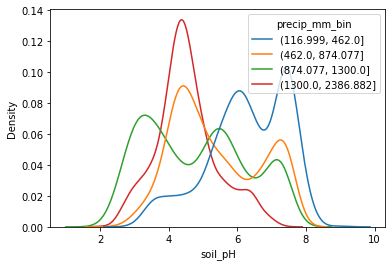

In [66]:
sns.kdeplot(clim_sdi, x="soil_pH", hue="precip_mm_bin")

<AxesSubplot:xlabel='soil_pH', ylabel='Density'>

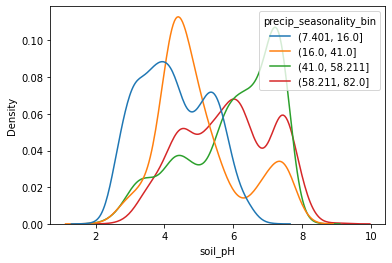

In [67]:
sns.kdeplot(clim_sdi, x="soil_pH", hue="precip_seasonality_bin")

<AxesSubplot:xlabel='soil_pH', ylabel='Density'>

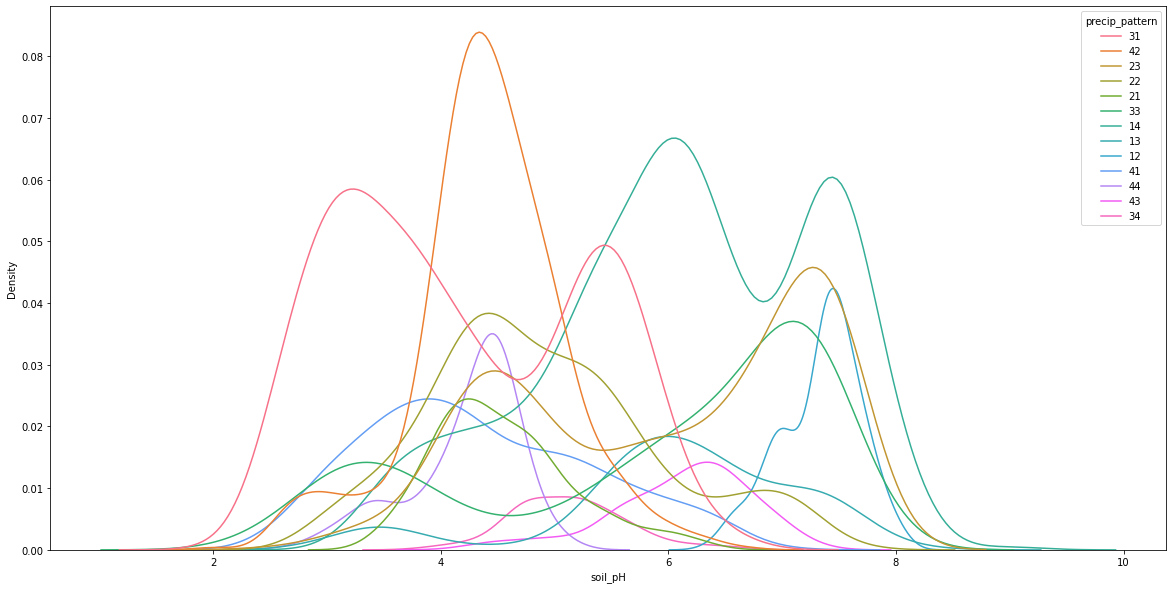

In [134]:
clim_sdi['precip_pattern'] = clim_sdi['precip_mm_bin'].astype(str) + clim_sdi['precip_seasonality_bin'].astype(str)
plt.figure(figsize=(20,10))
sns.kdeplot(clim_sdi, x="soil_pH", hue="precip_pattern")

In [135]:
scipy.stats.f_oneway(*[precip_pattern.values for name, precip_pattern in clim_sdi.groupby('precip_pattern')['shannon_diversity']])

F_onewayResult(statistic=39.73169412060874, pvalue=8.372263933755485e-91)

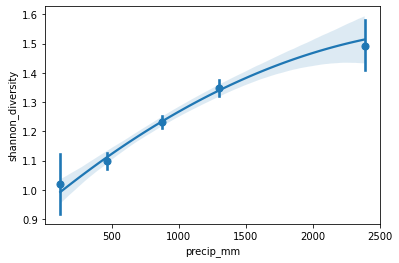

In [94]:
#Polynomial regression of precip bins on diversity across domains
# poly_facet = sns.FacetGrid(clim_sdi, col="domain", col_wrap=4)
# poly_facet.map_dataframe(sns.regplot, x="precip_mm", y="shannon_diversity", order=2)
sns.regplot(data=clim_sdi, x="precip_mm", y="shannon_diversity", x_bins=precip_mm_bins, order=2, ci=95);

<AxesSubplot:xlabel='precip_mm_bin', ylabel='shannon_diversity'>

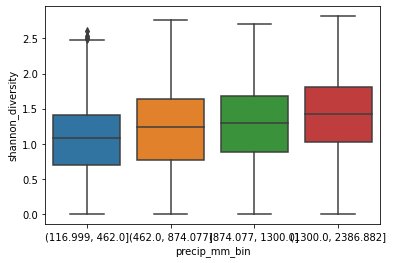

In [95]:
sns.boxplot(data=clim_sdi, x="precip_mm_bin", y="shannon_diversity")

<AxesSubplot:xlabel='precip_seasonality', ylabel='shannon_diversity'>

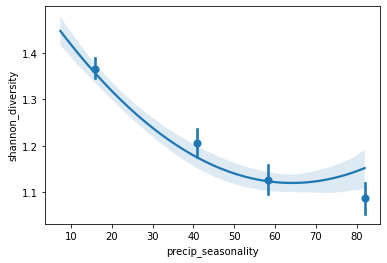

In [80]:
sns.regplot(data=clim_sdi, x="precip_seasonality", y="shannon_diversity", x_bins=precip_seasonality_bins[1:], order=2)

In [142]:
clim_sdi.groupby("precip_pattern")['domain'].agg("unique")

precip_pattern
12    [Great Basin, Southern Rockies / Colorado Plat...
13                              [Central Plains, Taiga]
14    [Northern Plains, Central Plains, Desert South...
21                [Southern Rockies / Colorado Plateau]
22    [Great Lakes, Southern Plains, Southern Rockie...
23    [Great Lakes, Prairie Peninsula, Southern Plains]
31    [Northeast, Mid Atlantic, Appalachians / Cumbe...
33    [Prairie Peninsula, Southeast, Atlantic Neotro...
34                                  [Pacific Southwest]
41                  [Appalachians / Cumberland Plateau]
42                          [Southeast, Ozarks Complex]
43                               [Atlantic Neotropical]
44                                  [Pacific Northwest]
Name: domain, dtype: object

<AxesSubplot:xlabel='soil_pH', ylabel='Density'>

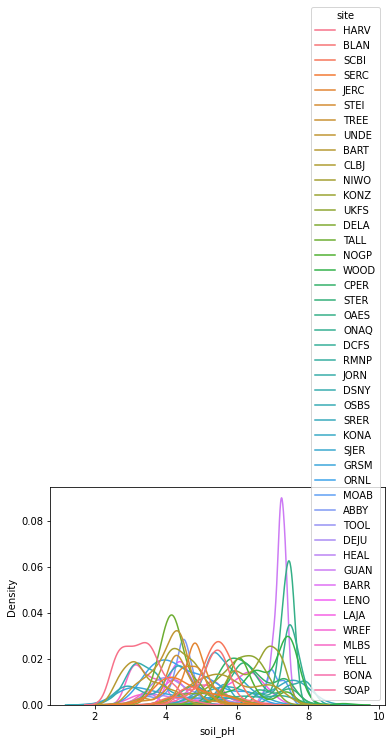

In [146]:
sns.kdeplot(data = clim_sdi, x="soil_pH", hue="site")

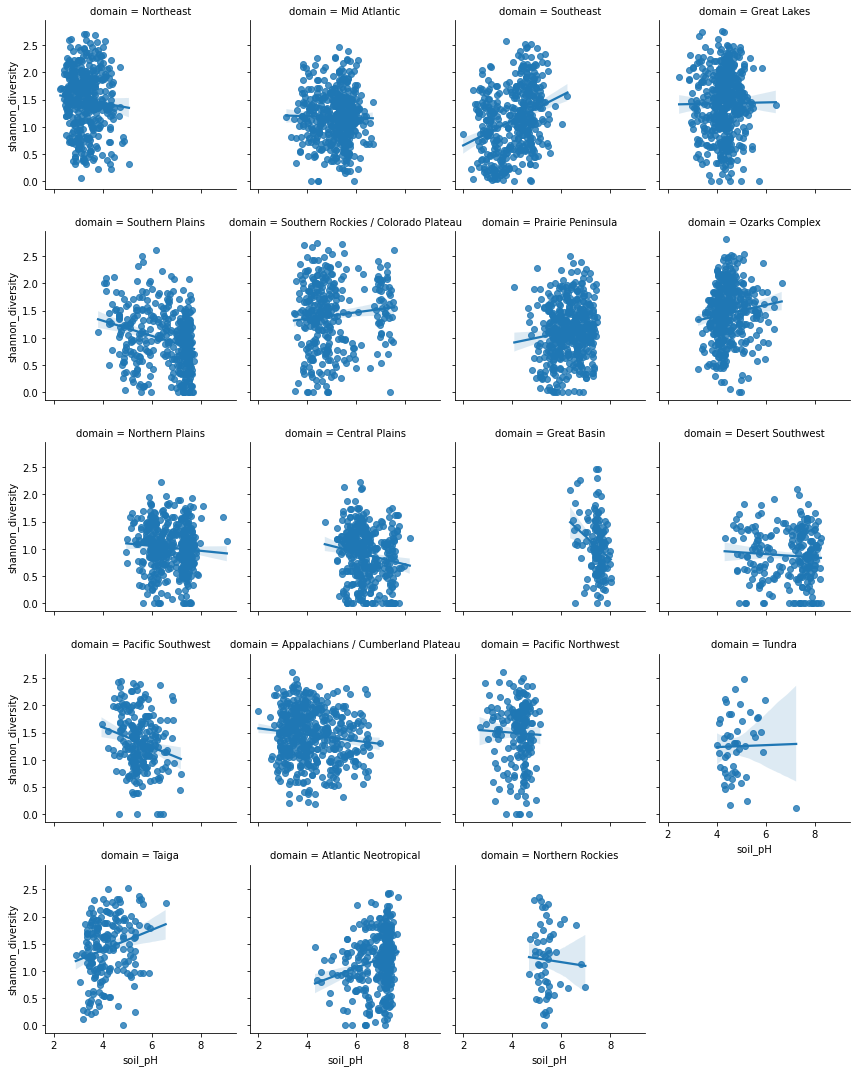

In [148]:
ecm_facet = sns.FacetGrid(data = clim_sdi, col="domain", col_wrap=4)
ecm_facet.map_dataframe(sns.regplot, x="soil_pH", y="shannon_diversity")

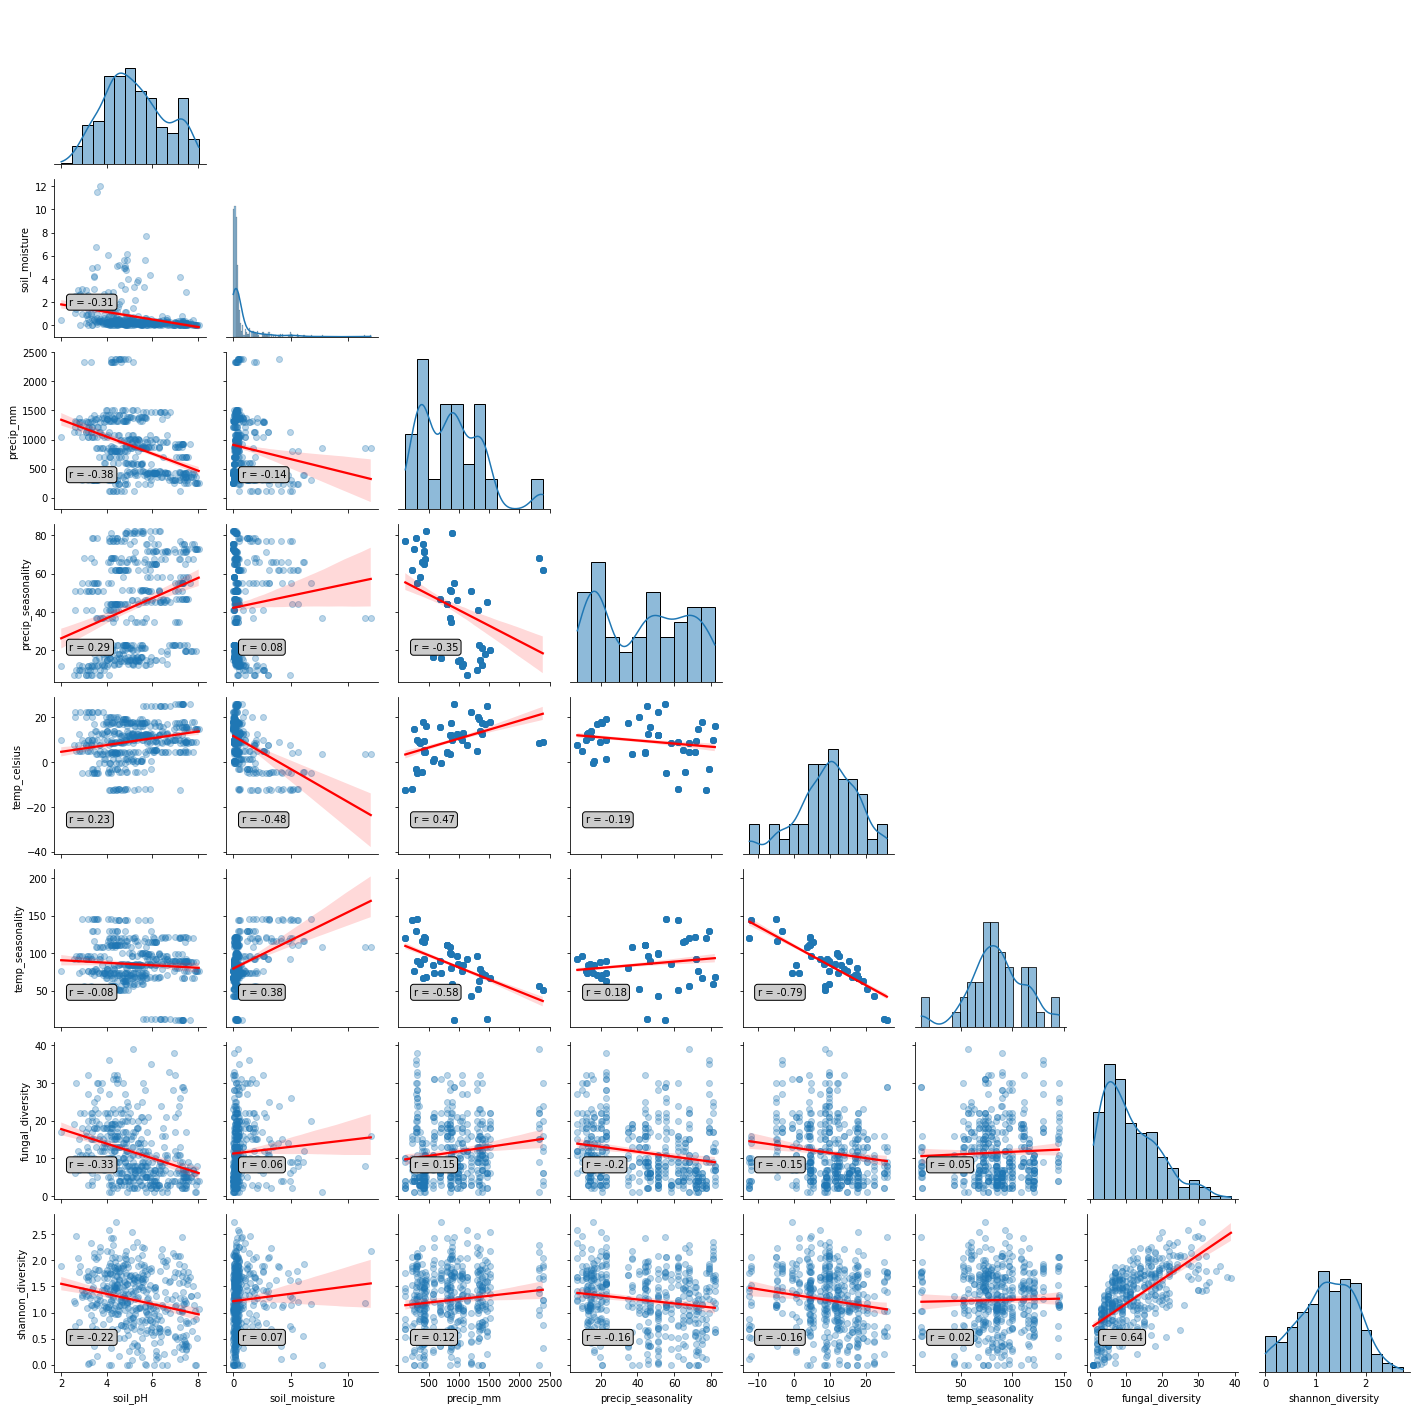

In [156]:
balanced_by_site = clim_sdi.dropna().groupby("site").sample(n=10, random_state=9)

corr_df = balanced_by_site[['soil_pH', 'soil_moisture', 'precip_mm', 'precip_seasonality', 'temp_celsius','temp_seasonality', 'fungal_diversity', 'shannon_diversity']]

def PlotCorrelationCoefficient(x, y, **kwargs):
    r, p = scipy.stats.pearsonr(x, y)
    sns.regplot(x=x, y=y, line_kws = {"color": "red"}, scatter_kws={"alpha":0.3})
    ax = plt.gca()
    ax.annotate(f'r = {r.round(2)}', (0.1, 0.2), xycoords=ax.transAxes, bbox={"boxstyle":"round", "fc":"0.8"})

corrplot = sns.PairGrid(corr_df, corner=True)
corrplot.map_diag(sns.histplot, kde=True)
corrplot.map_lower(PlotCorrelationCoefficient);

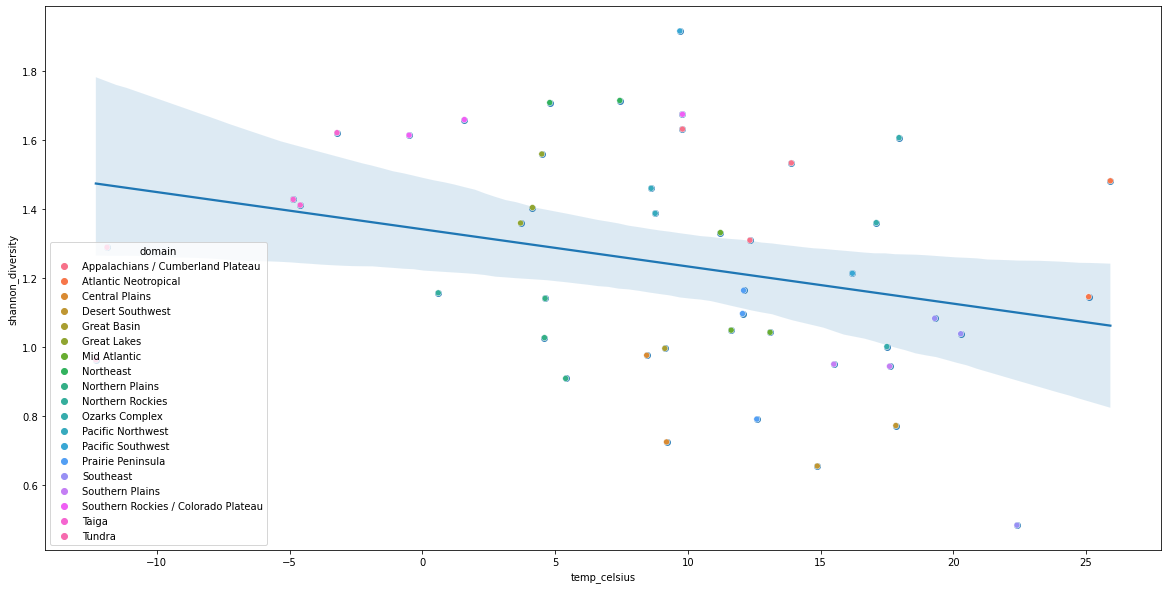

In [169]:
fig, ax = plt.subplots(figsize=(20,10))
var = "temp_celsius"

_ = balanced_by_site.groupby(["domain", "site"])['shannon_diversity', var].agg("mean").reset_index()
sns.regplot(_, x=var, y="shannon_diversity", ax=ax)
sns.scatterplot(_, x=var, y="shannon_diversity", ax=ax, hue="domain");